In [2]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import os
import sys
import cv2
import glob
from PIL import Image, ImageOps

In [3]:
sys.path.insert(1, '../python/')

In [4]:
from utils import get_lenet
from load_mnist import load_mnist
from conv_net import convnet_forward
from init_convnet import init_convnet

In [5]:
# Load the model architecture
layers = get_lenet()
params = init_convnet(layers)

In [6]:
# Load the network
data = loadmat('../results/lenet.mat')
params_raw = data['params']

In [7]:
for params_idx in range(len(params)):
    raw_w = params_raw[0,params_idx][0,0][0]
    raw_b = params_raw[0,params_idx][0,0][1]
    assert params[params_idx]['w'].shape == raw_w.shape, 'weights do not have the same shape'
    assert params[params_idx]['b'].shape == raw_b.shape, 'biases do not have the same shape'
    params[params_idx]['w'] = raw_w
    params[params_idx]['b'] = raw_b

In [120]:
#Load data
image_dir = "../images/"

images = []
image_name = []

file_list = os.listdir(image_dir)

for file in file_list:
    if "jpg" in file or "JPG" in file or "png" in file or "PNG" in file:
        img = cv2.imread(image_dir+file, cv2.IMREAD_GRAYSCALE)
        images.append(img)
        image_name.append(file)


In [222]:
# Convert the images to binary with a threshold

images_binary = []

for image in images:
    # Blur the image
    blur = cv2.GaussianBlur(image,(7,7),0)
    #grab each image based on threshold
    t_img = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21 , 25)
    images_binary.append(t_img)


In [220]:
# Truth Values

img_truth = []
img_truth.append("[2, 0, 6, 6, 6]")
img_truth.append("[9, 6, 7, 3, 8, 0, 5, 4, 2, 1]")
img_truth.append("[5, 9, 6, 8, 7, 0, 3, 4, 2, 1]")
img_truth.append("[2, 1, 0, 1, 4, 5, 4, 9, 7, 9, 6, 0, 1, 5, 3, 0, 9, 4, 9, 7, 6, 6, 1, 5, 0, 4, 0 , 9, 4, 7, 1, 3, 2, 1, 2, 1, 3, 4, 7, 7, 2, 2, 3, 1, 1, 5, 4, 7, 4, 4]")

In [228]:
# Go through each image, extract the digits and then feed it through the network

batch_size = 1
layers[0]['batch_size'] = batch_size

for i in range(len(images)):
    digit_imgs = [] #stores the digits this image composes of

    #grab the image name for print out
    img_name = image_name[i]

    #grab the binary image
    img = images_binary[i]

    #Find the connected components of the image

    num, _, box_stats, cpts = cv2.connectedComponentsWithStats(img, 8, cv2.CV_32S)

    for j in range(1,num):

        left = box_stats[j, cv2.CC_STAT_LEFT]
        right = left + box_stats[j, cv2.CC_STAT_WIDTH]-15
        top = box_stats[j, cv2.CC_STAT_TOP]
        bottom = top + box_stats[j, cv2.CC_STAT_HEIGHT]-10
        extract_digit = img[top:bottom,left:right]

        #pad the image
        pad_digit = cv2.copyMakeBorder(extract_digit, 9, 9, 9, 9, cv2.BORDER_CONSTANT, value=0)
        #resize image
        size_digit = cv2.resize(pad_digit,(28,28), interpolation=cv2.INTER_AREA)

        #add the image to array for queuing into the model
        digit_imgs.append(size_digit)
        # print("size of image {}".format(size_digit.shape))
    
    print(img_name)
    # print("number of digits found in image {}".format(len(digit_imgs)))

    #Feed the images into the network

    my_pred = []

    for k in range(len(digit_imgs)):
        cptest, P = convnet_forward(params, layers, digit_imgs[k], test=True)
        my_pred.append(P)

    my_pred_val = []
    # go through all the y_preds and get the index representing the predicted digit and store it
    for k in range(len(my_pred)):
        my_pred_val.append(np.argmax(my_pred[k]))
    
    print("Truth Values: ")
    print(img_truth[i])

    print("Image Predictions array: ")
    print(my_pred_val)
    print("---------------------------------")



image3.png
Truth Values: 
[2, 0, 6, 6, 6]
Image Predictions array: 
[2, 0, 2, 6, 3]
---------------------------------
image2.JPG
Truth Values: 
[9, 6, 7, 3, 8, 0, 5, 4, 2, 1]
Image Predictions array: 
[2, 2, 2, 0, 8, 0, 0, 4, 8, 7]
---------------------------------
image1.JPG
Truth Values: 
[5, 9, 6, 8, 7, 0, 3, 4, 2, 1]
Image Predictions array: 
[8, 7, 2, 2, 2, 2, 3, 2, 8, 3]
---------------------------------
image4.jpg
Truth Values: 
[2, 1, 0, 1, 4, 5, 4, 9, 7, 9, 6, 0, 1, 5, 3, 0, 9, 4, 9, 7, 6, 6, 1, 5, 0, 4, 0 , 9, 4, 7, 1, 3, 2, 1, 2, 1, 3, 4, 7, 7, 2, 2, 3, 1, 1, 5, 4, 7, 4, 4]
Image Predictions array: 
[3, 1, 1, 1, 4, 1, 6, 1, 2, 3, 1, 6, 6, 1, 6, 9, 6, 1, 1, 1, 7, 1, 1, 1, 6, 8, 1, 1, 1, 1, 1, 1, 1, 9, 1, 3, 1, 1, 2, 2, 5, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
---------------------------------


In [211]:
#Find connected components
#Referenced: https://pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/

#First work with one image, then eventually do it for all and append it to a growing list of digits
image = 3

img = images_binary[image]

num, _, box_stats, cpts = cv2.connectedComponentsWithStats(img, 8, cv2.CV_32S)

In [201]:
num

6

In [212]:
#ignore index 0 as that is the background image
digit_imgs = []
for i in range(1,num):

    left = box_stats[i, cv2.CC_STAT_LEFT]
    right = left + box_stats[i, cv2.CC_STAT_WIDTH]
    top = box_stats[i, cv2.CC_STAT_TOP]
    bottom = top + box_stats[i, cv2.CC_STAT_HEIGHT]
    extract_digit = img[top:bottom,left:right]

    #pad the image
    pad_digit = cv2.copyMakeBorder(extract_digit, 11, 11, 11, 11, cv2.BORDER_CONSTANT, value=0)
    #resize image
    size_digit = cv2.resize(pad_digit,(28,28), interpolation=cv2.INTER_AREA)
    digit_imgs.append(size_digit)




In [213]:
len(digit_imgs)

51

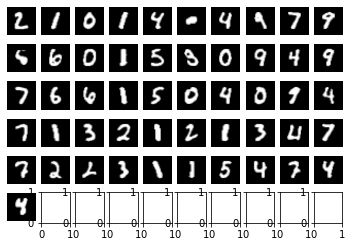

In [217]:
fig, ax = plt.subplots(6, 10)

im_num = 0

for row in range(6):
    for col in range(10):
        ax[row, col].set_axis_off()
        ax[row, col].imshow(digit_imgs[im_num], cmap='gray')
        im_num = im_num + 1
        if im_num > len(digit_imgs) - 1:
            break
    if im_num > len(digit_imgs) - 1:
            break

plt.savefig("fifty.png")

In [196]:
for i in range(len(digit_imgs)):
    Image.fromarray(digit_imgs[i]).show()


(gimp-2.10:34404): Gtk-WARNING **: 14:55:43.627: Unable to locate theme engine in module_path: "pixmap",

(gimp-2.10:34404): Gtk-WARNING **: 14:55:43.627: Unable to locate theme engine in module_path: "pixmap",

(gimp-2.10:34404): Gtk-WARNING **: 14:55:43.627: Unable to locate theme engine in module_path: "pixmap",

(gimp-2.10:34404): Gtk-WARNING **: 14:55:43.627: Unable to locate theme engine in module_path: "pixmap",

(gimp-2.10:34404): Gtk-WARNING **: 14:55:43.627: Unable to locate theme engine in module_path: "pixmap",

(gimp-2.10:34404): Gtk-WARNING **: 14:55:43.627: Unable to locate theme engine in module_path: "pixmap",

(gimp-2.10:34404): Gtk-WARNING **: 14:55:43.628: Unable to locate theme engine in module_path: "pixmap",

(gimp-2.10:34404): Gtk-WARNING **: 14:55:43.628: Unable to locate theme engine in module_path: "pixmap",

(gimp-2.10:34404): Gtk-WARNING **: 14:55:43.628: Unable to locate theme engine in module_path: "pixmap",

(gimp-2.10:34404): Gtk-WARNING **: 14:55:43.6

In [41]:
test = digit_imgs[1]
cv2.imshow("test", test)
cv2.waitKey(0)           

226

In [42]:
cv2.destroyAllWindows()

In [263]:
#Bounding boxes around connected components

# use box_stats and cpts (maybe not) to extract portions of the image up to range(num)

# observe the images, see if padding is necessary

# resize images to 28x28

# add it to digit_imgs 

# feed into network

In [264]:
#Extract images from the bounding boxes

In [265]:
#Pad or Resize to 28x28

In [266]:
# #Test with model
# my_pred = []
# for i in range(len(img_arr)):

#     cptest, P = convnet_forward(params, layers, img_arr[i], test=True)
#     my_pred.append(P)

#### For testing display

In [17]:
test = images_binary[3]
cv2.imshow("test", test)
cv2.waitKey(0) 

32

In [29]:
cv2.destroyAllWindows()